<a href="https://colab.research.google.com/github/hwangsae91/project_so/blob/master/exploration/221011/%5BExp_08%5D20221011.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
# google colab전용
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


※ 명령어를 통해 출력이 나오지 않게 하였다.

# exploration 9번째 과제
@ 황한용(3기/쏘카)

## 라이브러리 선언

In [17]:
import numpy as np
import pandas as pd
import tensorflow as tf

from collections import Counter
from gensim.models.keyedvectors import Word2VecKeyedVectors
from konlpy.tag import Mecab
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from typing import Dict, Tuple

## 상수선언

In [18]:
BASE_PATH = "/content/drive/MyDrive/Colab Notebooks/data/sentiment_classification" # 데이터 기본경로
DATA_PATH  = BASE_PATH + "/data" # 데이터 기본경로
MODEL_PATH = BASE_PATH + "/model/word2vec_ko.model" # 학습된 한국어 단어모델
STEP_WORDS = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다'] # 불용어
BASE_DICTONARY = ['<PAD>', '<BOS>', '<UNK>','<UNUSED>'] # 단어의 기본구성
FEATURE_DATA = ["document"] # feature
MAX_NUM_WORDS = 10000 # 최대 사전 단어갯수
WORD_VECTOR_DIM = 100 # 단어 백터 차원수
pad_seq_kwargs = {
    "value":None # 추후 추가예정
    , "padding":"post"
    , "maxlen":None # 추후 추가예정
}
TRAIN_TEST_SPLIT_KWARGS = {
    "test_size":0.4, "random_state":2022
}
fit_kwargs = {
    "epochs":15 # epoch 횟수
    , "batch_size":512
    ,"validation_data": None # 추후 추가예정
    , "shuffle" : True # epoch당 셔플을 할지의 여부
    , "verbose":1
}
tokenizer = Mecab() # tokenize 인스턴스
early_stopping = EarlyStopping(monitor="val_accuracy", patience=3)

## 함수

In [19]:
def load_data(
    train_data:pd.DataFrame
    , test_data:pd.DataFrame
    , step_words:list=STEP_WORDS
    , num_words:int=MAX_NUM_WORDS
) -> Tuple[
            np.ndarray
            , np.ndarray
            , np.ndarray
            , np.ndarray
            , Dict[int,str]
           , Dict[str,int]
        ]:
    """
    다음과 같은 전처리 후
    `train data(feature, target)`, `test data(feature, target)`, `단어사전(str기반, index기반)`
    을 리턴한다.

    - 데이터의 중복 제거
    - `NaN` 결측치 제거
    - 한국어 토크나이저로 토큰화
    - 불용어(`stop_words`) 제거
    - 사전`word_to_index` 구성
    - 텍스트 스트링을 사전 인덱스 스트링으로 변환

    Parameters
    ----------
    train_data : DataFrame
        학습 데이터
    train_data : DataFrame
        테스트 데이터
    step_words : list, default = `MAX_NUM_WORDS`
        불용어
    num_words : int, default = `MAX_NUM_WORDS`
        단어사전의 최대 단어 갯수

    Returns
    -------
    X_train : ndarray
        train feature data
    y_train : ndarray
        train target data
    X_test : ndarray
        test feature data
    y_test : ndarray
        test target data
    word_to_index : dict
        단어사전
    index_to_word : dict
        인덱스 기반 단어사전
    """
    # 1.
    train_data.drop_duplicates(subset=FEATURE_DATA, inplace=True)
    test_data.drop_duplicates(subset=FEATURE_DATA, inplace=True)

    # 2.
    train_data.dropna(how='any', inplace=True)
    test_data.dropna(how='any', inplace=True)

    # 3.
    X_train = [
        [word for word in tokenizer.morphs(sentence) if not word in step_words]
        for sentence in train_data['document']
    ]

    X_test = [
        [word for word in tokenizer.morphs(sentence) if not word in step_words]
        for sentence in test_data['document']
    ]
    
    # 4.
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words - len(BASE_DICTONARY))
    vocab = BASE_DICTONARY + [key for key, _ in counter]

    # 5.
    word_to_index = {word:index for index, word in enumerate(vocab)}
    index_to_word = {index:word for word, index in word_to_index.items()}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index, index_to_word

####################################### 제공 함수(사용안함) #######################################

# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 메인

### IMDB 데이터셋

In [20]:
train_data = pd.read_table(DATA_PATH + "/ratings_train.txt")
test_data = pd.read_table(DATA_PATH + "/ratings_test.txt")
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


데이터에 대한 설명은 아래와 같다.</br>
- id: The review id, provieded by Naver
- document: The actual review
- label: The sentiment class of the review. (0: negative, 1: positive)

In [21]:
X_train, y_train, X_test, y_test, word_to_index, index_to_word = load_data(train_data, test_data)

print(f"X_train len:{len(X_train)}")
print(f"X_test len:{len(X_test)}")

X_train len:146182
X_test len:49157


학습데이터와 테스트데이터를 로드

In [22]:
num_tokens = np.array(list(map(len,list(X_train) + list(X_test))))
# 문장길이의 평균값, 최대값, 표준편차를 계산 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_seq_kwargs.update({
    "value":word_to_index["<PAD>"]
    , "maxlen":maxlen
})# padding 설정

문장길이 평균 :  15.969376315021577
문장길이 최대 :  116
문장길이 표준편차 :  12.843535456326455
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


 최대 길이를 `maxlen`으로 설정하였고 값은 (평균 + 2*표준편차)로 하여<br>
대부분의 문장이 학습이 가능하도록 설정하였다.  

In [23]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, **pad_seq_kwargs)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, **pad_seq_kwargs)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, **TRAIN_TEST_SPLIT_KWARGS)
fit_kwargs["validation_data"] = (X_val, y_val)

과적합 방지를 위해 학습과 점증을 2:8비율로 나누었다. 

### 한국어 Word2Vec 임베딩

In [24]:
word_vectors = Word2VecKeyedVectors.load(MODEL_PATH).wv

# 임의의 가중치 적용
embedding_matrix = np.random.rand(MAX_NUM_WORDS, WORD_VECTOR_DIM)

# 이미 학습된 단어가 있는 경우 학습된 백터를 넣는다.
for i in range(4,MAX_NUM_WORDS):
    if index_to_word[i] in word_vectors:
        embedding_matrix[i] = word_vectors[index_to_word[i]]


기본에 학습된 모델을 로드 뒤, 같은 단어장에 가중치를 랜덤으로 적용 후,<br>
단어장 안에 학습된 단어가 존제하면 백터의 값을 대입한다.

In [25]:
model_list = []
w2v_model_list = []

# max pooling만 존제하는 model 설계
maxpool_model = tf.keras.Sequential(name = "maxpool_model")
maxpool_model.add(tf.keras.layers.Embedding(MAX_NUM_WORDS, WORD_VECTOR_DIM, input_shape=(None,)))
maxpool_model.add(tf.keras.layers.GlobalMaxPooling1D())
maxpool_model.add(tf.keras.layers.Dense(8, activation='relu'))
maxpool_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_list.append(maxpool_model)

w2v_maxpool_model = tf.keras.Sequential(name = "w2v_maxpool_model")
w2v_maxpool_model.add(tf.keras.layers.Embedding(
                                    MAX_NUM_WORDS 
                                    , WORD_VECTOR_DIM 
                                    , embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix)
                                    , input_length=maxlen 
                                    , trainable=True
                                 )
)
w2v_maxpool_model.add(tf.keras.layers.GlobalMaxPooling1D())
w2v_maxpool_model.add(tf.keras.layers.Dense(8, activation='relu'))
w2v_maxpool_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

w2v_model_list.append(w2v_maxpool_model)

max pooling만 존제하는 model 설계하였다.<br>
처음부터 학습하는 모델 `maxpool_model`<br>
기존에 학습된 데이터를 활용하는 `w2v_maxpool_model`<br>
로 나누어 설계하였다.

In [26]:
# CNN 1d model 설계
CNN_model = tf.keras.Sequential(name = "CNN_model")
CNN_model.add(tf.keras.layers.Embedding(MAX_NUM_WORDS, WORD_VECTOR_DIM, input_shape=(None,)))
CNN_model.add(tf.keras.layers.Dropout(rate=0.4))
CNN_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
CNN_model.add(tf.keras.layers.MaxPooling1D(5))
CNN_model.add(tf.keras.layers.Dropout(rate=0.4))
CNN_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
CNN_model.add(tf.keras.layers.GlobalMaxPooling1D())
CNN_model.add(tf.keras.layers.Dense(8, activation='relu'))
CNN_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_list.append(CNN_model)

w2v_CNN_model = tf.keras.Sequential(name = "w2v_CNN_model")
w2v_CNN_model.add(tf.keras.layers.Embedding(MAX_NUM_WORDS, 
                                 WORD_VECTOR_DIM, 
                                 embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
w2v_CNN_model.add(tf.keras.layers.Dropout(rate=0.4))
w2v_CNN_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
w2v_CNN_model.add(tf.keras.layers.MaxPooling1D(5))
w2v_CNN_model.add(tf.keras.layers.Dropout(rate=0.4))
w2v_CNN_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
w2v_CNN_model.add(tf.keras.layers.GlobalMaxPooling1D())
w2v_CNN_model.add(tf.keras.layers.Dense(8, activation='relu'))
w2v_CNN_model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

w2v_model_list.append(w2v_CNN_model)

CNN을 1차원으로 변형하여 학습하는 model 설계하였다.<br>
처음부터 학습하는 모델 `CNN_model`<br>
기존에 학습된 데이터를 활용하는 `w2v_CNN_model`<br>
로 나누어 설계하였다.

In [27]:
# RNN model 설계
RNN_model = tf.keras.Sequential(name = "RNN_model")
RNN_model.add(tf.keras.layers.Embedding(MAX_NUM_WORDS, WORD_VECTOR_DIM, input_shape=(None,)))
RNN_model.add(tf.keras.layers.LSTM(64, dropout=0.4))
RNN_model.add(tf.keras.layers.Dense(8, activation='relu'))
RNN_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_list.append(RNN_model)

w2v_RNN_model = tf.keras.Sequential(name = "w2v_RNN_model")
w2v_RNN_model.add(tf.keras.layers.Embedding(
                                 MAX_NUM_WORDS
                                 , WORD_VECTOR_DIM 
                                 , embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix)
                                 , input_length=maxlen 
                                 , trainable=True))
w2v_RNN_model.add(tf.keras.layers.LSTM(64, dropout=0.4))
w2v_RNN_model.add(tf.keras.layers.Dense(8, activation='relu'))
w2v_RNN_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

w2v_model_list.append(w2v_RNN_model)

RNN model 설계하였다.<br>
처음부터 학습하는 모델 `RNN_model`<br>
기존에 학습된 데이터를 활용하는 `w2v_RNN_model`<br>
로 나누어 설계하였다.

maxpool_model start
Epoch 1/15
172/172 [==============================] - 2s 6ms/step - loss: 0.6788 - accuracy: 0.7189 - val_loss: 0.6505 - val_accuracy: 0.7898
Epoch 2/15
172/172 [==============================] - 1s 5ms/step - loss: 0.6001 - accuracy: 0.8061 - val_loss: 0.5453 - val_accuracy: 0.8066
Epoch 3/15
172/172 [==============================] - 1s 5ms/step - loss: 0.4908 - accuracy: 0.8235 - val_loss: 0.4534 - val_accuracy: 0.8181
Epoch 4/15
172/172 [==============================] - 1s 5ms/step - loss: 0.4161 - accuracy: 0.8365 - val_loss: 0.4069 - val_accuracy: 0.8266
Epoch 5/15
172/172 [==============================] - 1s 5ms/step - loss: 0.3760 - accuracy: 0.8457 - val_loss: 0.3846 - val_accuracy: 0.8327
Epoch 6/15
172/172 [==============================] - 1s 5ms/step - loss: 0.3519 - accuracy: 0.8537 - val_loss: 0.3725 - val_accuracy: 0.8362
Epoch 7/15
172/172 [==============================] - 1s 5ms/step - loss: 0.3347 - accuracy: 0.8603 - val_loss: 0.3649 - val_acc

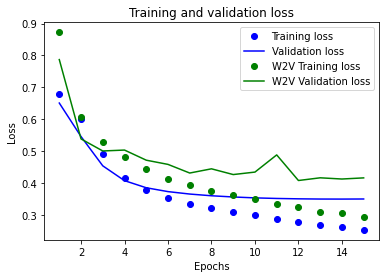

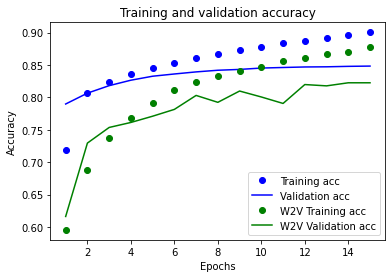

1537/1537 - 2s - loss: 0.3553 - accuracy: 0.8470 - 2s/epoch - 2ms/step
1537/1537 - 2s - loss: 0.4216 - accuracy: 0.8200 - 2s/epoch - 2ms/step
maxpool_model end

CNN_model start
Epoch 1/15
172/172 [==============================] - 3s 9ms/step - loss: 0.6918 - accuracy: 0.5287 - val_loss: 0.6840 - val_accuracy: 0.6766
Epoch 2/15
172/172 [==============================] - 1s 8ms/step - loss: 0.5862 - accuracy: 0.7169 - val_loss: 0.4533 - val_accuracy: 0.8019
Epoch 3/15
172/172 [==============================] - 1s 7ms/step - loss: 0.4315 - accuracy: 0.8065 - val_loss: 0.3946 - val_accuracy: 0.8256
Epoch 4/15
172/172 [==============================] - 1s 7ms/step - loss: 0.3941 - accuracy: 0.8272 - val_loss: 0.3773 - val_accuracy: 0.8357
Epoch 5/15
172/172 [==============================] - 1s 8ms/step - loss: 0.3742 - accuracy: 0.8397 - val_loss: 0.3682 - val_accuracy: 0.8400
Epoch 6/15
172/172 [==============================] - 1s 8ms/step - loss: 0.3586 - accuracy: 0.8476 - val_loss: 0

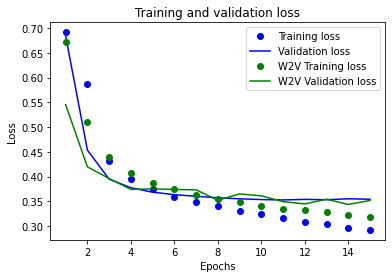

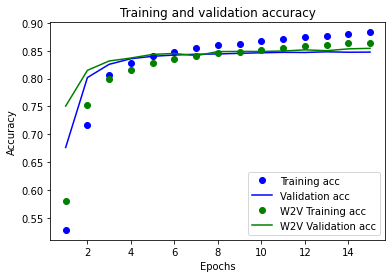

1537/1537 - 3s - loss: 0.3570 - accuracy: 0.8451 - 3s/epoch - 2ms/step
1537/1537 - 3s - loss: 0.3547 - accuracy: 0.8501 - 3s/epoch - 2ms/step
CNN_model end

RNN_model start
Epoch 1/15
172/172 [==============================] - 4s 12ms/step - loss: 0.6609 - accuracy: 0.5578 - val_loss: 0.4499 - val_accuracy: 0.7945
Epoch 2/15
172/172 [==============================] - 2s 9ms/step - loss: 0.4164 - accuracy: 0.8110 - val_loss: 0.3828 - val_accuracy: 0.8305
Epoch 3/15
172/172 [==============================] - 2s 9ms/step - loss: 0.3753 - accuracy: 0.8348 - val_loss: 0.3743 - val_accuracy: 0.8384
Epoch 4/15
172/172 [==============================] - 2s 9ms/step - loss: 0.3570 - accuracy: 0.8440 - val_loss: 0.3652 - val_accuracy: 0.8390
Epoch 5/15
172/172 [==============================] - 2s 9ms/step - loss: 0.3455 - accuracy: 0.8507 - val_loss: 0.3663 - val_accuracy: 0.8416
Epoch 6/15
172/172 [==============================] - 2s 9ms/step - loss: 0.3370 - accuracy: 0.8544 - val_loss: 0.38

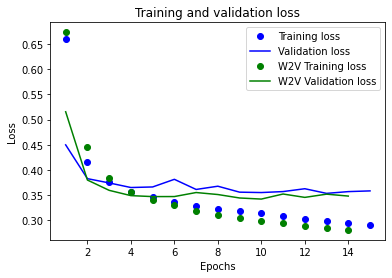

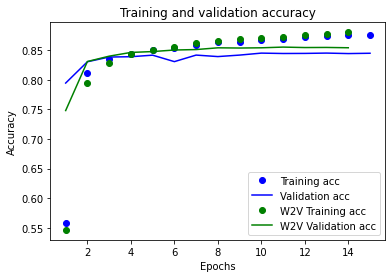

1537/1537 - 4s - loss: 0.3648 - accuracy: 0.8407 - 4s/epoch - 2ms/step
1537/1537 - 4s - loss: 0.3524 - accuracy: 0.8533 - 4s/epoch - 3ms/step
RNN_model end



In [28]:
for model, w2v_model in zip(model_list,w2v_model_list):
    print(f"{model.name} start")

    # 모델 훈련
    model.compile(optimizer=tf.keras.optimizers.Nadam(
                        learning_rate=0.0002 # running rate
                )
                ,loss='binary_crossentropy'
                ,metrics=['accuracy'])

    history_dict = model.fit(
                        X_train
                        , y_train
                        , callbacks=early_stopping
                        , **fit_kwargs
                    ).history
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']


    # 개선된 모델의 훈련
    w2v_model.compile(optimizer=tf.keras.optimizers.Nadam(
                        learning_rate=0.005 # running rate
                )
                ,loss='binary_crossentropy'
                ,metrics=['accuracy'])

    w2v_history_dict = w2v_model.fit(
                        X_train
                        , y_train
                        , callbacks=early_stopping
                        , **fit_kwargs
                    ).history

    w2v_acc = w2v_history_dict['accuracy']
    w2v_val_acc = w2v_history_dict['val_accuracy']
    w2v_loss = w2v_history_dict['loss']
    w2v_val_loss = w2v_history_dict['val_loss']

    epoch = range(1, len(acc) + 1)
    w2v_epoch = range(1, len(w2v_val_acc) + 1)

    plt.plot(epoch, loss, 'bo', label='Training loss')
    plt.plot(epoch, val_loss, 'b', label='Validation loss')
    plt.plot(w2v_epoch, w2v_loss, 'go', label='W2V Training loss')
    plt.plot(w2v_epoch, w2v_val_loss, 'g', label='W2V Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.clf()
    plt.plot(epoch, acc, 'bo', label='Training acc')
    plt.plot(epoch, val_acc, 'b', label='Validation acc')
    plt.plot(w2v_epoch, w2v_acc, 'go', label='W2V Training acc')
    plt.plot(w2v_epoch, w2v_val_acc, 'g', label='W2V Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    # 테스트셋을 통한 모델 평가
    results = model.evaluate(X_test, y_test, verbose=2)
    w2v_results = w2v_model.evaluate(X_test, y_test, verbose=2)

    print(f"{model.name} end\n")

둘의 학습결과 반드시 미리 학습된 데이터를 이용하여 학습, 예측하는 것이 좋은결과를 얻을 수 있지 않다는 결론에 달했다.<br>
먼저 학습률부터 다른점을 살펴보면<br>
- 처음부터 학습하는 모델이 경우는 learnning rate를 낮은 값으로 설정
- 미리 학습된 백터는 learnning rate를 높은 값으로 설정

하였을 시 결과가 가장 좋게 나왔다.<br>

early stop의 작동경우에는
- 비학습 모델에서는 early stop현상이 전혀 일어나지 않음
- 지도학습에서는 early stop이 가끔 일어남

의 현상이 보인다.<br>

이에따른 결과는
- max pool레이어만 존하는 모델은 비학습 모델이 전체적으로 높은 정확도가 나타나지만<br>전반적으로 학습률이 가장 저조함
- 그 이외의 모델에서는 학습된 모델이 1~2%정도 높게 나타나며<br>학습된 모델의 경우 항상 정확도가 85%를 넘음  

의 현상이 나타난다.



### 회고


- 학습된 데이터가 전체적으로 높은 정확도를 보여 미리 학습된 데이터의 중요성을 알게되었다.
- 항상 학습된 데이터가 높은 정확도를 나타내는 것이 아니라 하이퍼파라미터의 튜닝에 따라 결과가 달라질 수 있다는 것을 알게 되었다.

※ 이번 레포트는 양희성님의 모델구조의 조언으로 작성되었음을 알려드립니다.<br>
   희성님에게 감사하다는 글을 남기며 이만 글을 마치겠습니다.